In [109]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import randint, uniform
import seaborn as sns
import re
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import optuna
import shap
from sklearn.discriminant_analysis import StandardScaler

In [16]:
class SMOTETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.smote = SMOTE(random_state=self.random_state)

    def fit_resample(self, X, y):
        return self.smote.fit_resample(X, y)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X

In [17]:
# Load the data
train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')

# Impute missing ages with median
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())

# Impute missing embarkments
most_frequent_embarked = train_data['Embarked'].mode()[0]
train_data['Embarked'] = train_data['Embarked'].fillna(most_frequent_embarked)
test_data['Embarked'] = test_data['Embarked'].fillna(most_frequent_embarked)

# Combine train and test for preprocessing
all_data = pd.concat([train_data, test_data], sort=False).reset_index(drop=True)

In [75]:
# Feature Engineering
# Extract titles from names
all_data['Title'] = all_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

# Name-related features
all_data['NameLength'] = all_data['Name'].str.len()
surname_freq = all_data['Name'].str.split(',').str[0].value_counts()
all_data['SurnameFreq'] = all_data['Name'].str.split(',').str[0].map(surname_freq)

# Create family size feature
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1

# Create is_alone feature
all_data['IsAlone'] = 0
all_data.loc[all_data['FamilySize'] == 1, 'IsAlone'] = 1

# Extract deck from cabin
all_data['Deck'] = all_data['Cabin'].str.slice(0,1)
all_data['Deck'] = all_data['Deck'].fillna('U')

# Bin age
all_data['AgeBin'] = pd.cut(all_data['Age'], bins=[0, 12, 20, 40, 60, 100], labels=['Child', 'Teen', 'Adult', 'Senior', 'Elderly'])

# Fare-related features
all_data['FareBin'] = pd.qcut(all_data['Fare'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
all_data['FarePerPerson'] = all_data['Fare'] / all_data['FamilySize']

# Create interaction features
all_data['Age*Class'] = all_data['Age'] * all_data['Pclass']
all_data['Fare*Class'] = all_data['Fare'] * all_data['Pclass'] 
all_data['Sex*Pclass'] = all_data['Sex'].astype(str) + '_' + all_data['Pclass'].astype(str)
all_data['Age*Sex'] = all_data['AgeBin'].astype(str) + '_' + all_data['Sex'].astype(str)

# Derived features
all_data['FamilyType'] = pd.cut(all_data['FamilySize'], bins=[0, 1, 4, 20], labels=['Single', 'Small Family', 'Large Family'])
all_data['Title*Pclass'] = all_data['Title'] + '_' + all_data['Pclass'].astype(str)

# Cabin-related features
def extract_cabin_number(cabin):
    if pd.isna(cabin):
        return np.nan
    match = re.search(r'(\d+)', cabin)
    return float(match.group(1)) if match else np.nan

all_data['CabinNumber'] = all_data['Cabin'].apply(extract_cabin_number)
all_data['HasCabin'] = (~all_data['Cabin'].isna()).astype(int)
all_data['MultipleCabins'] = (all_data['Cabin'].str.count(' ') > 0).fillna(0).astype(int)

# Feature Selection
numeric_features = ['Age', 'Fare', 'FamilySize', 'NameLength', 'SurnameFreq', 'FarePerPerson']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'AgeBin', 'FareBin', 'IsAlone', 'Age*Class', 'Sex*Pclass', 'Age*Sex', 'FamilyType', 'Title*Pclass', 'Fare*Class']

In [76]:
# Split back into train and test
train_data = all_data[all_data['Survived'].notna()].copy()
test_data = all_data[all_data['Survived'].isna()].copy()

X = train_data[numeric_features + categorical_features]
y = train_data['Survived']

X.head(5)

,Age,Fare,FamilySize,NameLength,SurnameFreq,FarePerPerson,Pclass,Sex,Embarked,Title,Deck,AgeBin,FareBin,IsAlone,Age*Class,Sex*Pclass,Age*Sex,FamilyType,Title*Pclass,Fare*Class
0,22.0,7.2500,2,23,2,3.62500,3,male,S,Mr,U,Adult,Low,0,66.0,male_3,Adult_male,Small Family,Mr_3,21.7500
1,38.0,71.2833,2,51,2,35.64165,1,female,C,Mrs,C,Adult,Very High,0,38.0,female_1,Adult_female,Small Family,Mrs_1,71.2833
2,26.0,7.9250,1,22,1,7.92500,3,female,S,Miss,U,Adult,Medium,1,78.0,female_3,Adult_female,Single,Miss_3,23.7750
3,35.0,53.1000,2,44,2,26.55000,1,female,S,Mrs,C,Adult,Very High,0,35.0,female_1,Adult_female,Small Family,Mrs_1,53.1000
4,35.0,8.0500,1,24,2,8.05000,3,male,S,Mr,U,Adult,Medium,1,105.0,male_3,Adult_male,Single,Mr_3,24.1500


In [77]:
# Encode categorical variables
categorical_encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = pd.DataFrame(categorical_encoder.fit_transform(X[categorical_features]))
X_encoded.columns = categorical_encoder.get_feature_names_out(categorical_features)

# Combine with numeric features
X_numeric = X[numeric_features].reset_index(drop=True)
X_preprocessed = pd.concat([X_numeric, X_encoded], axis=1)

In [78]:
# Perform mutual information analysis
mi_scores = mutual_info_classif(X_preprocessed, y)
mi_scores = pd.Series(mi_scores, index=X_preprocessed.columns)
mi_scores = mi_scores.sort_values(ascending=False)

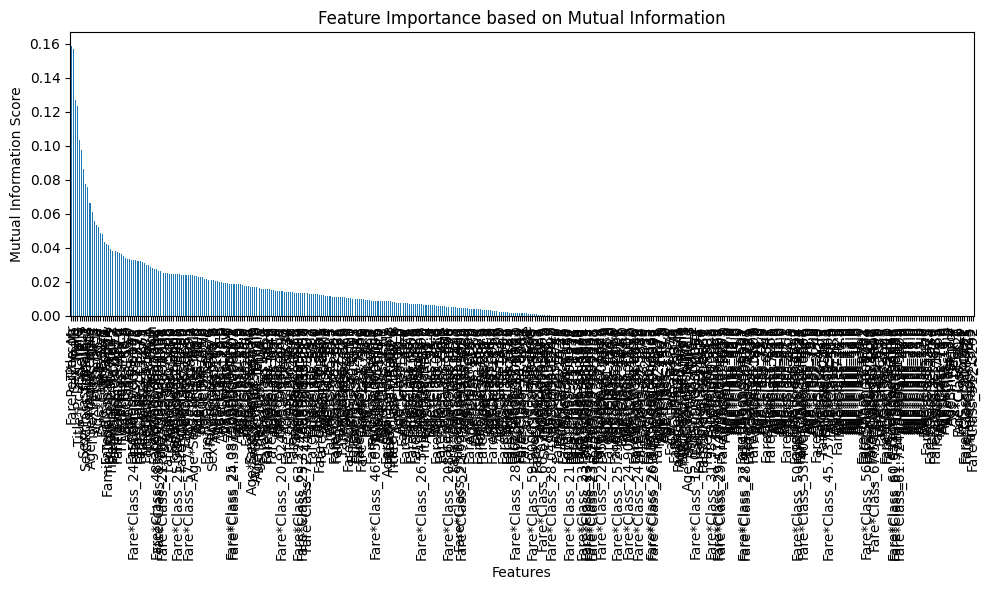

In [79]:
# Plot mutual information scores
plt.figure(figsize=(10, 6))
mi_scores.plot.bar()
plt.title('Feature Importance based on Mutual Information')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.tight_layout()
plt.show()

In [80]:
# Select top K features
k_best_features = SelectKBest(mutual_info_classif, k=20)
X_new = k_best_features.fit_transform(X_preprocessed, y)
selected_feature_names = X_preprocessed.columns[k_best_features.get_support()]

print("Top 20 features selected:", selected_feature_names)

Top 20 features selected: Index(['Fare', 'FamilySize', 'NameLength', 'FarePerPerson', 'Pclass_3',
       'Sex_male', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_U',
       'Sex*Pclass_female_2', 'Sex*Pclass_male_2', 'Sex*Pclass_male_3',
       'Age*Sex_Adult_male', 'Age*Sex_Senior_male', 'FamilyType_Small Family',
       'Title*Pclass_Miss_1', 'Title*Pclass_Miss_2', 'Title*Pclass_Mr_3',
       'Fare*Class_21.75'],
      dtype='object')


In [81]:
# Select only the top 15 features
X_selected = X_preprocessed[selected_feature_names]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, 
    y, 
    test_size=0.4,  # 40% of the data will be used for testing
    random_state=42,  # Set a random state for reproducibility
    stratify=y  # Ensure that the proportion of samples for each class is the same in both train and test sets
)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training set shape: (534, 20)
Testing set shape: (357, 20)
Training labels shape: (534,)
Testing labels shape: (357,)


In [82]:
# Pipelines
# All columns will be treated as features
features = X_train.columns.tolist()

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', StandardScaler())  # Scale all features
])

# Fit the pipeline to the training data
preprocessing_pipeline.fit(X_train)

# Transform both training and testing data
X_train_preprocessed = preprocessing_pipeline.transform(X_train)
X_test_preprocessed = preprocessing_pipeline.transform(X_test)

# Convert to DataFrames to keep feature names
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=features)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=features)

print("Shape of preprocessed training data:", X_train_preprocessed.shape)
print("Shape of preprocessed testing data:", X_test_preprocessed.shape)
print("\nSample of preprocessed training data:")
print(X_train_preprocessed.head())

Shape of preprocessed training data: (534, 20)
Shape of preprocessed testing data: (357, 20)

Sample of preprocessed training data:
       Fare  FamilySize  NameLength  FarePerPerson  Pclass_3  Sex_male  \
0 -0.463691   -0.570526   -0.849159      -0.303623  0.893297  0.743186   
1 -0.114701    0.129844    0.876629      -0.197971 -1.119448 -1.345558   
2 -0.151940    0.129844   -0.849159      -0.220502  0.893297  0.743186   
3 -0.331174    0.830213    1.308076      -0.390837  0.893297 -1.345558   
4 -0.479124   -0.570526   -0.741297      -0.322298  0.893297  0.743186   

   Title_Miss  Title_Mr  Title_Mrs    Deck_U  Sex*Pclass_female_2  \
0   -0.503509  0.853320  -0.422857  0.523892            -0.303355   
1   -0.503509 -1.171893   2.364866  0.523892             3.296463   
2   -0.503509  0.853320  -0.422857  0.523892            -0.303355   
3   -0.503509 -1.171893   2.364866  0.523892            -0.303355   
4   -0.503509  0.853320  -0.422857  0.523892            -0.303355   

   Sex*P

In [83]:
# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42)
}

# Function to evaluate model
def evaluate_model(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

In [91]:
# Set up StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare results dictionary
results = {name: {metric: [] for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']} for name in models.keys()}

# Perform cross-validation
for train_index, val_index in skf.split(X_train_preprocessed, y_train):
    X_train_fold, X_val_fold = X_train_preprocessed.iloc[train_index], X_train_preprocessed.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    for name, model in models.items():
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        fold_results = evaluate_model(y_val_fold, y_pred)
        
        for metric, value in fold_results.items():
            results[name][metric].append(value)

# Calculate mean and std of metrics across folds
summary = {}
for name in models.keys():
    summary[name] = {metric: {'mean': np.mean(values), 'std': np.std(values)} 
                     for metric, values in results[name].items()}

# Print results
for name, metrics in summary.items():
    print(f"\n{name}:")
    for metric, values in metrics.items():
        print(f"{metric}: {values['mean']:.4f} (+/- {values['std']:.4f})")


Random Forest:
Accuracy: 0.7997 (+/- 0.0438)
Precision: 0.7679 (+/- 0.0774)
Recall: 0.6927 (+/- 0.0569)
F1 Score: 0.7268 (+/- 0.0577)

Gradient Boosting:
Accuracy: 0.8109 (+/- 0.0319)
Precision: 0.7852 (+/- 0.0652)
Recall: 0.7073 (+/- 0.0378)
F1 Score: 0.7424 (+/- 0.0375)

Logistic Regression:
Accuracy: 0.7922 (+/- 0.0156)
Precision: 0.7559 (+/- 0.0462)
Recall: 0.6878 (+/- 0.0625)
F1 Score: 0.7166 (+/- 0.0255)

SVM:
Accuracy: 0.8165 (+/- 0.0297)
Precision: 0.7877 (+/- 0.0567)
Recall: 0.7220 (+/- 0.0548)
F1 Score: 0.7511 (+/- 0.0388)


In [92]:
# Identify the best model based on mean F1 Score
best_model = max(summary, key=lambda x: summary[x]['F1 Score']['mean'])
print(f"\nBest model based on mean F1 Score: {best_model}")


Best model based on mean F1 Score: SVM


In [97]:
# Train the best model on the entire training set and evaluate on the test set
best_model_instance = models[best_model]
best_model_instance.fit(X_train_preprocessed, y_train)
y_pred_test = best_model_instance.predict(X_test_preprocessed)
test_results = evaluate_model(y_test, y_pred_test)

print(f"\nBest model ({best_model}) performance on test set:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")


Best model (SVM) performance on test set:
Accuracy: 0.8375
Precision: 0.8264
Recall: 0.7299
F1 Score: 0.7752


In [106]:
# Define the hyperparameter search space based on the best model
if best_model == 'Random Forest':
    param_distributions = {
        'n_estimators': np.arange(100, 501, 50),
        'max_depth': np.arange(5, 31, 5),
        'min_samples_split': np.arange(2, 21, 2),
        'min_samples_leaf': np.arange(1, 11),
        'max_features': ['sqrt', 'log2', None]
    }
elif best_model == 'Gradient Boosting':
    param_distributions = {
        'n_estimators': np.arange(100, 501, 50),
        'learning_rate': np.logspace(-3, 0, 20),
        'max_depth': np.arange(3, 11),
        'min_samples_split': np.arange(2, 21, 2),
        'min_samples_leaf': np.arange(1, 11),
        'subsample': np.linspace(0.7, 1.0, 10)
    }
elif best_model == 'Logistic Regression':
    param_distributions = {
        'C': np.logspace(-3, 3, 20),
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': np.arange(100, 501, 100)
    }
elif best_model == 'SVM':
    param_distributions = {
        'C': np.logspace(-3, 3, 20),
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto'] + list(np.logspace(-3, 0, 10)),
        'degree': [2, 3, 4, 5]  # Only used by poly kernel
    }
else:
    raise ValueError(f"Unexpected model type: {best_model}")
     

In [108]:
# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=models[best_model],
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Use F1 score to evaluate performance
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV
random_search.fit(X_train_preprocessed, y_train)

# Print the best parameters and score
print("Best parameters found:")
print(random_search.best_params_)
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:
{'kernel': 'rbf', 'gamma': np.float64(0.021544346900318832), 'degree': 5, 'C': np.float64(2.976351441631316)}
Best cross-validation score: 0.7426


In [110]:
# Evaluate the model with best parameters on the test set
best_model_tuned = random_search.best_estimator_
y_pred_test_tuned = best_model_tuned.predict(X_test_preprocessed)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred_test_tuned)
precision = precision_score(y_test, y_pred_test_tuned)
recall = recall_score(y_test, y_pred_test_tuned)
f1 = f1_score(y_test, y_pred_test_tuned)

print("\nPerformance on test set after hyperparameter tuning:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Performance on test set after hyperparameter tuning:
Accuracy: 0.8403
Precision: 0.8226
Recall: 0.7445
F1 Score: 0.7816


In [111]:
# Compare with the performance before tuning
print("\nComparison with performance before tuning:")
print(f"F1 Score (before tuning): {test_results['F1 Score']:.4f}")
print(f"F1 Score (after tuning): {f1:.4f}")
print(f"Improvement: {f1 - test_results['F1 Score']:.4f}")


Comparison with performance before tuning:
F1 Score (before tuning): 0.7752
F1 Score (after tuning): 0.7816
Improvement: 0.0064
